## A program to read ERA-I level data and do cross-spectral Analysis
552 Homework 8 2023 Cross-Spectral Analysis
Dennis L. Hartmann February 8, 2023

In [45]:
# open necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy import stats
import math
import os
from scipy.io import netcdf
import scipy.signal as sig
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import netCDF4 as nc
from cartopy import config
from netCDF4 import Dataset 
from scipy.optimize import curve_fit

In [49]:
# read in data and set up spectral analysis
# here we are reading in two global fields of a variable at one level
# the choices of variables are U,V&T, the choices of levels are 200 and 850
# there is no T200 file, so don't choose that one
# The data files are called 552_T850.nc, 552_V850.nc, 552_U850.nc, 552_T850.nc, 
#  552_U200.nc, , 552_V200.nc 
#* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
var = 'V'
var2 = 'V'
pressure = '850' 
pressure2 = '200'
#* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

ncfile = '552_'+var+pressure+'.nc'
ncfile2 = '552_'+var2+pressure2+'.nc'
data_name = var+pressure
data_name2 = var2+pressure2
print('data names ',data_name,' - ',data_name2)
fn = '/path/to/file.nc4'
ds = nc.Dataset(ncfile)
ds2 = nc.Dataset(ncfile2)
print(ds)
u = ds[data_name][:]
print('shape u ',np.shape(u))
lon = ds['lon'][:]
lat = ds['lat'][:]
v = ds2[data_name2][:]
# extend longitude array
lonp = np.empty(len(lon)+1)
lonp[0:len(lon)] = lon
lonp[len(lon)]= lon[len(lon)-1]+lon[1]-lon[0]
print('lonp ',np.shape(lonp))
print('lonp[-1] ',lonp[-1])
print('lonp ',np.shape(lonp))
#  shapes of two arrays
print('shape u ',np.shape(u))
print('shape v ',np.shape(v))

 

data names  V850  -  V200
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: 552_Cross-Spectral_Analysis_Data
    subtitle: V-8500hPa
    dimensions(sizes): lat(121), lon(240), time(14610)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float64 V850(time, lat, lon)
    groups: 
shape u  (14610, 121, 240)
lonp  (241,)
lonp[-1]  360.0
lonp  (241,)
shape u  (14610, 121, 240)
shape v  (14610, 121, 240)


(121, 240)
ump  (121, 241)
usp  (121, 241)


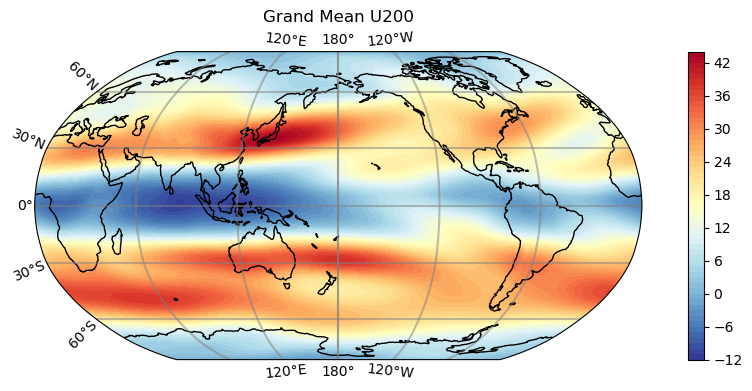

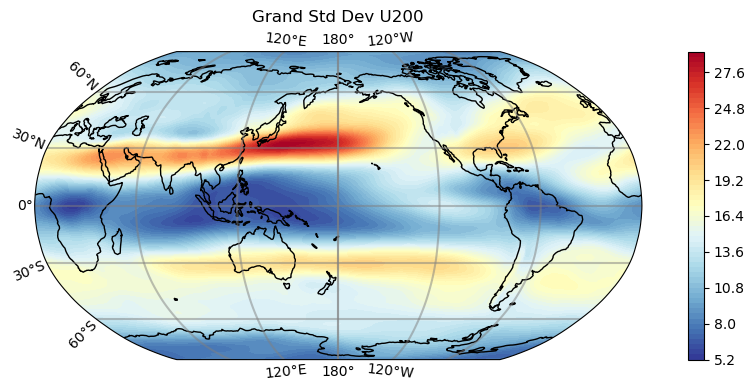

In [47]:
# OK we have successfully read in the data array
# let's plot mean and variance
# you can skip this section to save time, 
#but it might be interesting to see maps before selecting locations
cent_lon=180.
um = np.nanmean(v,0)  # note using second varible v here
us = np.nanstd(v,0)
print(np.shape(um))
# Here we are adding cyclic continuity to variable, so it plots without gaps
ump = np.empty([len(lat),len(lon)+1])
print('ump ',np.shape(ump))
ump[:,0:len(lon)]= um
ump[:,len(lon+1)]= um[:,0]
usp = np.empty([len(lat),len(lon)+1])
print('usp ',np.shape(usp))
usp[:,0:len(lon)]= us
usp[:,len(lon+1)]= us[:,0]
# plot the grand mean
# let's try to plot a long-term mean
#col_map = 'coolwarm'
col_mapc = 'RdYlBu_r'
col_mapr = 'RdYlBu_r'
plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
#  I like a central longitude of 150W for showing the ocean the best
#  It puts the Pacific in the center and the cut at a longitude of maximum in continentality
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
plt.contourf(lonp, lat, ump, 60, cmap=col_mapc,
             transform=ccrs.PlateCarree())
plt.title('Grand Mean '+var2+pressure2)
ax.coastlines()
plt.grid()
plt.colorbar()
#plt.colorbar(location='bottom')
plt.show()
# plot the grand standard deviation
# 
plt.figure(figsize=(12, 4), dpi=100)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=cent_lon))
#  I like a central longitude of 150W for showing the ocean the best
#  It puts the Pacific in the center and the cut at a longitude of maximum in continentality
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
plt.contourf(lonp, lat, usp, 60, cmap=col_mapc,
             transform=ccrs.PlateCarree())
plt.title('Grand Std Dev '+var2+pressure2)
ax.coastlines()
plt.grid()
plt.colorbar()
#plt.colorbar(location='bottom')
plt.show()
   

dlat, dlon -1.5 1.5
ia,ib,ja,jb 160 160 60 60
shape x  (14610,)
shape test  (9, 14610)
shape time  (14610,)
type time  <class 'numpy.ndarray'>
type test  <class 'numpy.ndarray'>
acx, axy  0.339 0.667
len f, rs 65 65
max rs_x  2.027838690242012
fcritx, fcrity,  1.24 1.24
max rsxs  2.568950556608946
shape f (65,)
shape Pxy (65,)


Text(0.5, 1.0, 'Covariance = Real Cospectra')

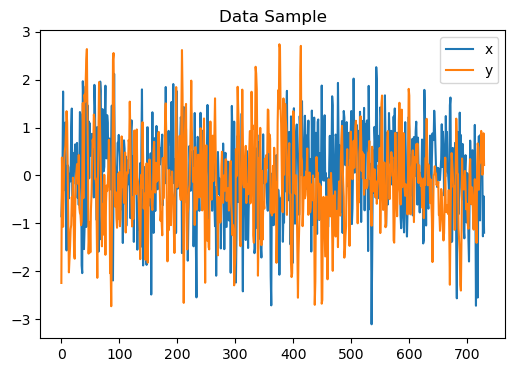

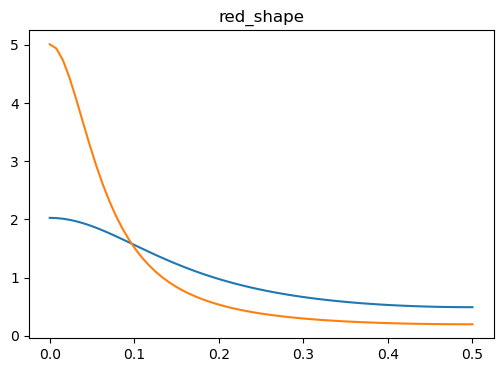

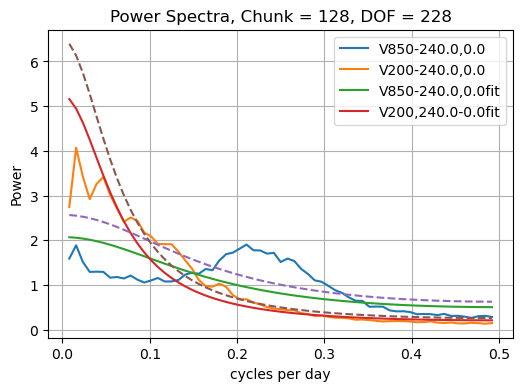

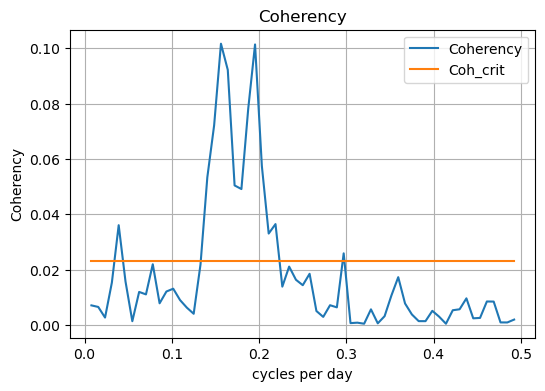

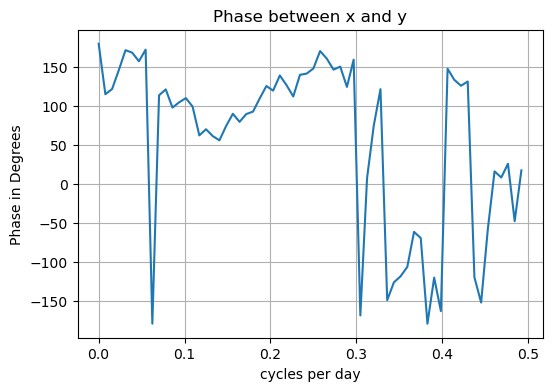

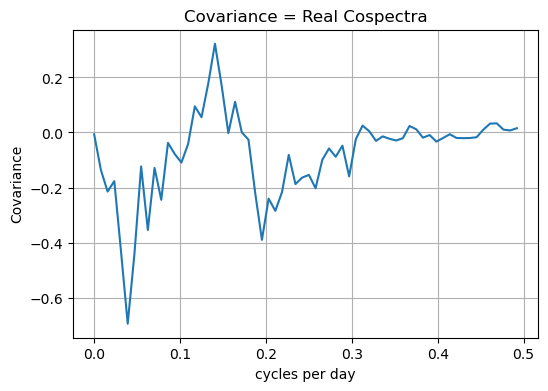

In [60]:
# specify points to compare
# here we have our two global fields and we are going to down-select to a latitude-longitude point for each
# a corresponds to field u and b to field v
#* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
p_crit = 0.99  # significanc level requred a priori
lona=240.
lonb=240.
lata=0.0
latb=0.0

M_window = 128   # chunk length
remove_trend = True
remove_annual = True
norm_spec = True  # make area under spectrum constant
prewhite = False   # option to prewhiten
red_noise_null = True  # if true plots a red noise fit, if False multiplies spectrum by Fcrit
red_noise_fit = False
normalize_series = True
nfrac = 1.0  # fraction of Nyquist interval to plot
#* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

dlat=lat[1]-lat[0]
dlon=lon[1]-lon[0]
print('dlat, dlon',dlat,dlon)

ifx=int(M_window/2*nfrac)
# compute indices of those points
ia = int(lona/dlon)
ib = int(lonb/dlon)
ja = int((lata-90.)/dlat)
jb = int((latb-90.)/dlat)
print('ia,ib,ja,jb',ia,ib,ja,jb)
x = np.squeeze(u[:,ja,ia])
y= np.squeeze(v[:,jb,ib])

if remove_trend:
    x = sig.detrend(x)
    y = sig.detrend(y)
    
if remove_annual:  # remove annual cycle from record by regression on harmonics
    test = np.zeros((9,len(x)),dtype=float)
    test[0,:] = np.ones(len(x))
    time=np.arange(0,len(x))*2*np.pi/365.25
    test[1,:]=np.sin(time)
    test[2,:]=np.cos(time);
    test[3,:]=np.sin(2.*time)
    test[4,:]=np.cos(2.*time)
    test[5,:]=np.sin(3.*time)
    test[6,:]=np.cos(3.*time)
    test[7,:]=np.sin(4.*time)
    test[8,:]=np.cos(4.*time)
    # Project test functions onto time series
    print('shape x ',np.shape(x))
    print('shape test ',np.shape(test))
    print('shape time ',np.shape(time))
    print('type time ',type(time))
    print('type test ',type(test))
    cx=np.matmul(test,x)/len(x)
    cy=np.matmul(test,y)/len(y)
    x=x-np.matmul(cx.data,test)
    y=y-np.matmul(cy.data,test)
    cx=np.matmul(test,x)/len(x)  # rinse and repeat  I found this was necessary to remove more of semi-annual wave
    cy=np.matmul(test,y)/len(y)
    x=x-np.matmul(cx.data,test)
    y=y-np.matmul(cy.data,test)
    cx=np.matmul(test,x)/len(x)  # rinse and repeat
    cy=np.matmul(test,y)/len(y)
    x=x-np.matmul(cx.data,test)
    y=y-np.matmul(cy.data,test)
else:
    y=y-np.nanmean(y)
    x=x-np.nanmean(x)
if normalize_series:  # make variance one
    y = y/np.std(y)
    x = x/np.std(x)        
# makes some plots to check annual cycle removal
plt.figure(figsize=(6,4))
plt.plot(x[0:730])
plt.plot(y[0:730])
plt.legend(('x','y'))
plt.title('Data Sample')
def acor(x):
    xd = (x -np.mean(x))/np.std(x)
    acor = np.dot(xd[0:len(xd)-1],xd[1:len(x)])/(len(xd)-1)
    #acor = np.sqrt(acor)
    return acor
acx = acor(x)
acy = acor(y)
print('acx, axy ',"{:.3f}".format(acx),"{:.3f}".format(acy))
def prewhiten(x,ac):
    y = x
    x[1:len(x)]=y[1:len(x)]-ac*y[0:len(x)-1]
    return x

if prewhite:
    x = prewhiten(x,acx)
    y = prewhiten(y,acy)
    acx = acor(x)
    acy = acor(y)
# COMPUTE POWER we are overlapping by 50% (the default), and detrending each segment
f, Pxx = sig.welch(x,nperseg=M_window,noverlap=M_window/2,detrend='linear')
f, Pyy = sig.welch(y,nperseg=M_window,noverlap=M_window/2,detrend='linear')
if norm_spec:
    Pxx = Pxx/np.mean(Pxx)
    Pyy = Pyy/np.mean(Pyy)
#print('shape f',np.shape(f))
#print('shape Pxx',np.shape(Pxx))
#  compute rednoise null hypothesis

def red_shape(f,ac,A):
    rs = A*(1.0-ac**2)/(1. -(2.0*ac*np.cos(f*2.0*np.pi))+ac**2)
    return rs
# compute the Gilman et al shape for red noise
rs_x = red_shape(f,acx,1.0)
rs_y = red_shape(f,acy,1.0)
plt.figure(figsize=(6,4))
plt.plot(f, rs_x, f, rs_y)
plt.title('red_shape')
print('len f, rs',len(f),len(rs))
print('max rs_x ',np.max(rs_x))
rsx = rs_x*np.sum(Pxx[1:len(Pxx)])/np.sum(rs_x[1:len(rs_x)]) # compute rs matched to Pxx 
rsy = rs_y*np.sum(Pyy[1:len(Pyy)])/np.sum(rs_y[1:len(rs_y)]) # skipping f=0 the mean
nun = 2.0*len(x)/M_window   # DOF of spectrum conservative estimate
dun = len(x)/2  # DOF of denominator Null Hypothesis
#****************************************************
#  Fit spectrum to determine autocorrelation - new idea
# 
if red_noise_fit:
    parameters, covariance = curve_fit(red_shape, f, Pxx, p0 =(0.5,1.0))
    parameters1, covariance1 = curve_fit(red_shape, f, Pyy, p0 =(0.5,1.0)) 
    fit_A = parameters[0]
    fit_B = parameters[1]
    fit_A1 = parameters1[0]
    fit_B1 = parameters1[1]
    print('fit_A, fit_B, ',fit_A,fit_B)
    print('fit_A1, fit_B1, ',fit_A1,fit_B1) 
    rsx = red_shape(f, fit_A, fit_B)
    rsy = red_shape(f, fit_A1, fit_B1)
    plt.figure(figsize=(6,4))
    plt.plot(f, rsx, f, rsy)
    plt.title('red_shape fits')
#****************************************************
#plt.title('Gilman structure')


def get_fcrit(p_crit,nun,dun):
    for n in range(200):
        f=1.+float(n)/50.
        p_val = stats.f.cdf(f,nun,dun)
        if p_val > p_crit:
            f_crit = f
            break
    return f_crit
f_crity = get_fcrit(p_crit,nun,dun)
f_critx = get_fcrit(p_crit,nun,dun)
print('fcritx, fcrity, ',f_critx,f_crity)

if red_noise_null:
    rsys = rsy*f_crity  # computing the line we need to exceed Red Noise Theory
    rsxs = rsx*f_critx
else:
    rsys = Pyy*f_crity  # computing the line we need to exceed Eyeball Method
    rsxs = Pxx*f_critx
print('max rsxs ',np.max(rsxs))
plt.figure(figsize=(6,4))
plt.plot(f[1:ifx],Pxx[1:ifx],f[1:ifx],Pyy[1:ifx],f[1:ifx],rsx[1:ifx],f[1:ifx],rsy[1:ifx])
plt.plot(f[1:ifx],rsxs[1:ifx],'--',f[1:ifx],rsys[1:ifx],'--')
plt.xlabel('cycles per day')
plt.ylabel('Power')
plt.legend((var+pressure+'-'+str(lona)+','+str(lata),var2+pressure2+'-'+str(lonb)+','+str(latb),var+pressure \
            +'-'+str(lona)+','+str(lata)+'fit',var2+pressure2+','+str(lonb)+'-'+str(latb)+'fit'))
plt.grid()
plt.title('Power Spectra, Chunk = '+str(M_window) + ', DOF = '+str(int(nun)))
# Compute Cross Spectra
f, Pxy = sig.csd(x,y,nperseg=M_window,detrend='linear')
f, Coh = sig.coherence(x,y,nperseg=M_window,detrend='linear')
# note that Pxy is complex
print('shape f',np.shape(f))
print('shape Pxy',np.shape(Pxy))
def cohstat(dof,siglev):
    #Siglev, significance level desired, should be .95 or .99. Siglev greater
    #than .95 will default to .99, lower inputs of siglev default to .95

    # this is a rough fit to the F statistic (0.01), assuming the denominator has 100 dof.
    #f=[3.94,3.09,3.98,3.51,3.21,2.99,2.82,2.69,2.59,2.5,2.07,1.89,1.80,1.74,1.65,1.60];
    #n=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100];
    # this is a rough fit to the Coherency statistic (0.01), given dof as input.
    f99 = [0.99,0.684,0.602,0.536,0.482,0.438,0.401,0.342,0.264,0.215,0.175,0.147,0.112,0.075,0.057,0.045,0.023,0.002];
    f90 = [0.901,0.437,0.370,0.319,0.280,0.250,0.226,0.189,0.142,0.112,0.091,0.076,0.057,0.038,0.029,0.023,0.011,0.001];
    f95 = [0.951,0.527,0.450,0.393,0.348,0.312,0.283,0.238,0.181,0.146,0.118,0.098,0.074,0.050,0.037,0.030,0.015,0.001];
    n=[2,5,6,7,8,9,10,12,16,20,25,30,40,60,80,100,200,1000000];

    if  siglev > 0.95:
        f = f99;
    else:
        f = f95
    coh_crit = np.interp(dof,n,f)
    return coh_crit
coh_crit = cohstat(nun,p_crit)
Coh_crit = np.ones(M_window+1)*coh_crit
plt.figure(figsize=(6,4))
plt.plot(f[1:ifx],Coh[1:ifx],f[1:ifx],Coh_crit[1:ifx])
plt.xlabel('cycles per day')
plt.ylabel('Coherency')
plt.legend(('Coherency','Coh_crit'))
plt.title('Coherency, dof= '+str(int(nun)))
plt.grid()
plt.title('Coherency')
# compute phase from arctan2(imag, real)
phase = np.arctan2(np.imag(Pxy),np.real(Pxy))*180/np.pi
plt.figure(figsize=(6,4))
plt.plot(f[0:ifx],phase[0:ifx])
plt.xlabel('cycles per day')
plt.ylabel('Phase in Degrees')
plt.grid()
plt.title('Phase between x and y')
rcross = np.real(Pxy)
plt.figure(figsize=(6,4))
plt.plot(f[0:ifx],rcross[0:ifx])
plt.xlabel('cycles per day')
plt.ylabel('Covariance')
plt.grid()
plt.title('Covariance = Real Cospectra')